In [69]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statistics as stat
from scipy.stats import iqr
from scipy.stats import bootstrap
import scipy.stats as ss
from scipy.stats import binom
from scipy.optimize import curve_fit
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from statsmodels.tools.eval_measures import rmse
from sklearn.linear_model import LinearRegression
import random
import scipy.integrate as integrate
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import BernoulliNB,  MultinomialNB, GaussianNB 
from sklearn import metrics
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix


# Classification

In [70]:
df = pd.read_csv("cleaned_data.csv")
df.head(3)
df.drop(columns='id', inplace=True)




### Naive Bayes

Naive bayes is a set of supervised learning algorithm based on the bayes'theorem. The latter gives the probability $P$ that an event $y$ occurs knowing that the events $x_1,x_2,$ and $x_3$ occured:

$P(y|x_1,x_2,x_3) = \frac{P(y)P(x_1,x_2,x_3|y)}{P(x_1,x_2,x_3)}$

$P(y|x_1,x_2,x_3)$ : Probability that $y$ will occur knowing $x_1,x_2,$ and $x_3$ occured <br>
$P(x_1,x_2,x_3|y)$ : Probability that $x_1,x_2,x_3$ will occur knowing $y$ occured <br>
$P(x_1,x_2,x_3)$ : Probability that $x_1,x_2,x_3$ will occur <br>
$P(y)$ : Probability that $y$ will occur <br>

We can already see that in a classification context this is already very useful. For example, based on the content of an email (occurence of some words: dear,friend, money) we could compute the probability of being a spam or a normal mail. Thus, we will classify a mail (dear=1,friend=0, money=5) depending on which class (spam or normal) presents the highest probability.

The naive term comes form the fact that we consider the features as independents. Taking the previous example, we assume that the presence "dear", "friend", and "money" in the mail is independent. This allows the following simplication:

$P(x_1,x_2,x_3|y) = P(x_1|y) P(x_2|y) P(x_3|y)$ <br>
$P(x_1,x_2,x_3) = P(x_1) P(x_2) P(x_3)$ <br> <br>
which makes the calculation easier. Indeed, the $P(x_1|y)$ can be obtained as the number of occurence $x_1$ knowing $y$ appearing in the training set, and $P(x_1)$ is the number of occurence of $x_1$. For example, P(dear|spam) is the number of "dear" appearing in spam emails in our training set.

We can see that the way I described so far the calculation of $P(x_1|y)$ can be only applied to count. But it exits different naive Bayes classifiers that differs mainly according to the form of $P(x_1|y)$:

* Multinomial Naive Bayes
    * Good for counting features (e.g., how often a word appears in a document).
* Gaussian Naive Bayes
    * Used for features with a Gaussian distribution.
* Bernoulli Naive Bayes
    * Designed for binary/boolean features.
* Complement Naive Bayes
    * Suited for imbalanced data sets, and is a variation of MultinomialNB.

#### Applications

Here's an overview of various applications along with the specific Naive Bayes methods best suited for each:

* Text Classification
    * Multinomial Naive Bayes: Optimal for handling the frequency counts of words or features in text documents.
    * Complement Naive Bayes: Particularly effective for imbalanced data sets, often found in real-world text classifications.
* Medical Diagnostics
    * Gaussian Naive Bayes: Used when predicting diseases from continuous data like blood test results, where feature values are assumed to follow a Gaussian distribution.
* Real Estate Pricing
    * Gaussian Naive Bayes: Applicable when modeling prices based on features with normal distributions, such as size or age of the property.

#### Limitations

* Assumption of features independence
    * This assumption rarely holds in real-world data, where features often influence each other. 
* Zero-frequency problem
    * In a record ($x_1,x_2,x_3$) when there is no occurence in the training set of a feature value (e.g. $x_1$) corresponding to class label ($y$), $P(x_1|y)$ will be zero so as $P(y|x_1,x_2,x_3)$. This can degrade the naive bayes performance and its robustness. One way to mitigate it is by using Laplace smoothing.

#### Example

In this example, I will develop and evaluate a Gaussian Naive Bayes classifier that predicts whether individuals are likely to experience a stroke. I will start with a very simple model taking into account only the body mass index (BMI).

In [71]:
#1 Define the X and y variables

X = df[["bmi"]]
y = df["stroke"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=11)

#2 Fit the model
nb_gauss = GaussianNB().fit(X_train,y_train)

#3 Test the model and output the result
y_predict = nb_gauss.predict(X_test)

print(f'Accuracy of the prediction : {round(metrics.accuracy_score(y_test, y_predict)*100,1)}% \n \n'
      f'% of stroke in the test set {round(np.sum(y_test==1)/len(y_test)*100,1)}%')


Accuracy of the prediction : 94.5% 
 
% of stroke in the test set 5.5%


Using only one feature, I obtained 94.5% of accuracy. This high accuracy is actually not a witness of the model performance but is due to the imbalanced target variable, where only 5.5% of the test set actually represents stroke cases. Indeed, a naive model that predicts 'non-stroke' for all cases will present the same accuracy score of 94.5%. For conditions like stroke, missing a positive case can have severe consequences. Therefore, relying on accuracy as a standalone metric in such scenarios is not only ineffective but potentially dangerous. Other metrics are currently used for classification and method for handling imbalanced data set:

## Evaluating Classification Models

### Confusion Matrix

A confusion matrix is a table used to evaluate the performance of a classification model on a set of test data where the true values are known. This matrix is structured as a 2x2 contingency table, where the rows represent the true classes and the columns represent the predicted classes. The elements on the diagonal of the matrix reflect the number of instances that the model correctly predicted, known as True Positives (TP) and True Negatives (TN). The off-diagonal elements, conversely, represent the instances where the model's predictions were incorrect, showing False Positives (FP) and False Negatives (FN).


|                   | Predicted Positive       | Predicted Negative       |
|-------------------|--------------------------|--------------------------|
| Actual Positive   | True Positives (TP)      | False Negatives (FN)     |
| Actual Negative   | False Positives (FP)     | True Negatives (TN)      |


Here's the definitions: <br>
**True Positives** (TP): Instances correctly predicted as positive. <br>
**True Negatives** (TN): Instances correctly predicted as negative. <br> 
**False Positives** (FP): Instances incorrectly predicted as positive (also known as Type I error). <br>
**False Negatives** (FN): Instances incorrectly predicted as negative (also known as Type II error). <br>


#### Applications  
The values obtained from the confusion matrix serve as the foundation for calculating key metrics well known to describe the expected performance of diagnostic tests:

* Recall or True Positive Rate or sensitivity: Among all the actual positive cases, how many have been correctly classified by the model. It is straightforward to obtain from the confusion matrix:

$\frac{True Positives}{True Positives + False Negatives}$

* Precision: Among all the predicted positive cases, how many are actual positive cases:

$\frac{True Positive}{False Positives + True Positive}$

* Specificity: Amonng all the actual negative case, how many have been correctly classified.

$\frac{True Negatives}{False Positives + True Negatives}$


#### Example

Here, I will develop a more advanced Gaussian Naive Bayes model including all the features. Here the following steps:
1. Preprocess the Data
    * Encode categorical variables
    * Standardize the continuous variables
2. Construct the model
    * Define the model
    * Split the data into training and testing sets.
    * Train the classifier
3. Evaluate the Model
    * Accuracy
    * Confusion matric
    * Precision
    * Recall



In [72]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix

#1 Preprocess the Data

# Identify categorical and continuous columns
categorical_cols = df.select_dtypes(include=['object']).columns
continuous_cols = ['age', 'avg_glucose_level', 'bmi']

# Create a column transformer to apply different preprocessing to different columns
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), continuous_cols),
        ('cat', OneHotEncoder(), categorical_cols)
    ])

#2 Construct the model

# Create a pipeline that first preprocesses the data then fits a Gaussian Naive Bayes classifier
clf_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', GaussianNB())
])

# Split data into features and target
X = df.drop('stroke', axis=1)
y = df['stroke']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the Naive Bayes classifier
clf_pipeline.fit(X_train, y_train)
y_predict = clf_pipeline.predict(X_test)


#3 Evaluate the Model

cm = confusion_matrix(y_test, y_predict)
tn, fp, fn, tp = cm.ravel()
df_cm = pd.DataFrame(cm, index=[i for i in ["No stroke", "Stroke"]], 
                     columns=[i for i in ["Predicted no stroke", "Predicted stroke"]])

print("Confusion Matrix with 50% Threshold:\n", df_cm)
accuracy = (tn+tp)/(tn+fp+ fn+ tp)
precision = (tp)/(tp+fp)
recall = (tp)/(tp+fn)
specificity = (tn) / (tn+fp)

print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"Specificity: {specificity:.2f}")



Confusion Matrix with 50% Threshold:
            Predicted no stroke  Predicted stroke
No stroke                  690               234
Stroke                      16                38
Accuracy: 0.74
Precision: 0.14
Recall: 0.70
Specificity: 0.75



There is an inherent trade-off between recall (sensitivity) and specificity. Enhancing recall, which involves correctly identifying more true positives,  typically results in a increase of the number of false positives (misclassifying label 0 as label 1), and thus a decrease in specificity. 

Classifications are generally based on the probability that a record belongs to one category or another. By default, many classifiers use a threshold of 50% to make this determination. However, adjusting this threshold can help favor one label over the other. For instance, setting a threshold of 80% means a record is classified as label 1 only if the probability of it belonging to label 1 is greater than 80%; otherwise, it is classified as label 0. Adjusting the threshold in this manner typically decreases the false positives but increases the false negatives (misclassifying label 1 as label 0), consequently enhancing precision at the expense of recall. The "Receiver Operating Characteristics" or ROC curve is a crucial tool for evaluating this balance:


### Receiver Operating Characteristics (ROC)

 This curve graphically represents a classifier's performance by plotting recall (sensitivity) on the vertical axis against the false positive rate (1 - specificity) on the horizontal axis. The ROC curve illustrates how the trade-off between recall and specificity shifts as the threshold is adjusted, providing a visual means to determine the optimal balance between these metrics.

 #### Example

Here, I will use the ROC curve to optimize the optimal threshold. Here are the steps: 

1. Compute Predicted Probabilities 
    * For each record in the test compute the probability to have a stroke
2. Plot ROC Curve:
    * The curve represents the trade-off between the true positive rate (sensitivity) and the false positive rate (1-specificity) as the classification threshold varies.
4. Find Optimal Threshold
    *  The optimal threshold is determined by maximizing the difference between true positive rate and false positive rate (i.e., maximizing the Youden's index). 

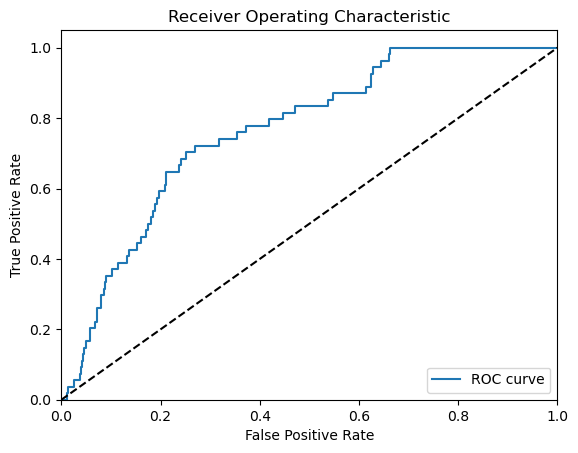

Optimal threshold: 0.46


In [73]:
from sklearn.metrics import roc_curve

# Assuming y_probs are the probabilities of the positive class
## For each row (record) it give a list of the probability to be label 1: P(y=1|x1,x2,x3...)
y_probs = clf_pipeline.predict_proba(X_test)[:, 1]

# Generate ROC curve data
fpr, tpr, thresholds = roc_curve(y_test, y_probs)


# Plot ROC Curve
plt.figure()
plt.plot(fpr, tpr, label='ROC curve')
plt.plot([0, 1], [0, 1], 'k--')  # Random predictions curve
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Find the optimal threshold
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
print("Optimal threshold: %.2f" % optimal_threshold)




We can see when we increasing the True Positive Rate (ability to correctly classified label 1) we also increasing the miclassification label 0 to 1 (False Positive Rate). I found a trade-off by maximising the difference True Positive and False Positive Rate for a threshold of 0.46. The latter classes a record label 1 if the $P(y=1|x1,x2,x3..) >= 46%$ or equivalently $P(y=0|x1,x2,x3..) <= 54%$. Compared to the default threshold of 50%, we increase of the missclassification of label 0 but increase classification of label 1?


Now I will use the optimal threshold to make final predictions and evaluates the model's performance:

In [83]:


# Apply the optimal threshold to make final predictions
y_pred_optimal = (y_probs >= optimal_threshold).astype(int)
cm_optimal = confusion_matrix(y_test, y_pred_optimal)
tn, fp, fn, tp = cm_optimal.ravel()

df_cm_optimal = pd.DataFrame(cm_optimal, index=[i for i in ["No stroke", "Stroke"]], 
                     columns=[i for i in ["Predicted no stroke", "Predicted stroke"]])

print(f"Confusion Matrix with Optimal Threshold ({round(optimal_threshold,2)}):\n", df_cm_optimal)

# Calculate new performance metrics
accuracy = (tn+tp)/(tn+fp+ fn+ tp)
precision = (tp)/(tp+fp)
recall = (tp)/(tp+fn)
specificity = (tn) / (tn+fp)


print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"Specificity: {specificity:.2f}")


Confusion Matrix with Optimal Threshold (0.46):
            Predicted no stroke  Predicted stroke
No stroke                  675               249
Stroke                      15                39
Accuracy: 0.73
Precision: 0.14
Recall: 0.72
Specificity: 0.73


After adjusting the threshold to 0.46, the recall slightly improved to 0.72, indicating that the model became better at identifying actual stroke cases. However, this improvement lower the specificity, which decreased to 0.73, reflecting a minor increase in the rate of false positives, i.e., non-stroke cases incorrectly classified as strokes. This trade-off between recall and specificity is significant in medical applications, where the cost of missing a true positive (a stroke case) can be very high, potentially leading to severe health consequences. 


### Strategies for Imbalanced Data


In many real-world classification tasks, we often encounter datasets with imbalanced target data, where one class is more prevalent than the other. This scenario is common in medical diagnostics for predicting diseases within a population or in detecting fraud. In these cases, the less common class is usually of greater importance and typically labeled as 1. The misclassification of these critical cases as 0s (negative) is more detrimental than falsely identifying non-cases (0s) as 1s (positive). Nonetheless, most predictive models are designed to maximize overall accuracy, which can lead to a bias towards the majority class. This occurs because a model might achieve high accuracy simply by predominantly predicting the more frequent class. Additionally, these models often do not generalize well to the minority class due to the limited number of examples available to learn from.


#### Strategies
* **Undersampling** : This technique involves reducing the number of examples from the majority class to balance the class distribution. The goal is to decrease the size of the larger class by randomly eliminating records.
    * Pros: Helps balance the datased.
    * Cons: Potential loss of valuable data that could be important for model training.
    * Use Case: Effective when the dataset is sufficiently large, and the risk of losing information is minimal.
* **Oversampling and Up/Down Weighting** : It involves replicating data points from the minority class to equalize the class proportions (done by bootstrapping). Up/Down weighting adjusts the weights of the data based on their frequency.
    * Pros: Helps in learning rare events without losing valuable data.
    * Cons: Can lead to overfitting due to the repetition of minority class samples.
    * Use Case: Useful when the dataset size is small.
* **Data Generation** : Synthetic data generation techniques like SMOTE (Synthetic Minority Over-sampling Technique) or ADASYN are used to create artificial samples based on the existing minority class samples.
    * Pros: Enhances the training process by introducing variability in the minority class.
    * Cons: Synthetic samples may not perfectly represent real-world scenarios. Need numerical data.
    * Use Case: Ideal when more samples are needed, and the minority class is too small to provide sufficient information on its own.
* **Cost-Based Classification** : This approach modifies the learning algorithm so that it assigns a higher cost to misclassifying the minority class. Essentially, the model is penalized more for misclassifying a minority class than a majority class.
    * Pros: Directly focuses on reducing the type of errors that are more consequential to the problem.
    * Cons: Requires careful tuning to avoid biasing the model excessively towards the minority class.
    * Use Case: Best suited for situations where the costs of misclassification are high, such as in fraud detection or medical diagnosis.


#### Example

In the following, I will apply the different strategies to the studied dataset. For that I will construct a function that takes as arguments: the dataframe, the classifier (e.g. GaussianNB()), and the strategy of imbalanced data (e.g. SMOTE). Here the steps:

1. Preprocessing Setup:
    * Identifies and processes categorical features using OneHotEncoder and continuous features using StandardScaler.
2. Resampling Configuration:
    * Depending on the chosen strategy (smote, undersample, or oversample), the appropriate resampling technique is applied to address class imbalance.
3. Pipeline Construction:
    * An ImbPipeline is constructed which combines preprocessing, resampling, and the classifier to ensure correct workflow and prevent data leakage.
4. Data Splitting and Model Training:
    * The dataset is split into training and testing sets, and the model is trained using the training data.
5. Model Evaluation:
    * Performance is evaluated using a confusion matrix and metrics like accuracy, precision, recall, and specificity, providing insights into the classifier’s effectiveness.

In [75]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import confusion_matrix
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as ImbPipeline

def train_and_evaluate_model(df, classifier=GaussianNB(), strategy='smote', random_state=123, test_size=0.2):
    """
    Trains and evaluates a model with specified classifier and resampling method.
    
    Parameters:
    - df: DataFrame, the dataset to use.
    - classifier: Classifier, the machine learning model to train.
    - strategy: str, defines the strategy as 'smote', 'undersample', or 'oversample'.
    - random_state: int, the random state for reproducibility.
    - test_size: float, the proportion of the dataset to include in the test split.
    """
    # Preprocessing setup
    categorical_cols = df.select_dtypes(include=['object']).columns
    continuous_cols = ['age', 'avg_glucose_level', 'bmi']
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), continuous_cols),
            ('cat', OneHotEncoder(), categorical_cols)
        ])
    
    # Define the resampling
    if strategy == 'smote':
        sampler_step = ('sampler', SMOTE(random_state=random_state))
    elif strategy == 'undersample':
        sampler_step = ('sampler', RandomUnderSampler(random_state=random_state))
    elif strategy == 'oversample':
        # Here oversample might refer to using a SMOTE with a different configuration
        sampler_step = ('sampler', SMOTE(sampling_strategy='auto', random_state=random_state))
    else:
        raise ValueError("Unsupported strategy. Choose 'smote', 'undersample', or 'oversample'.")

    # Define the pipeline
    clf_pipeline = ImbPipeline(steps=[
        ('preprocessor', preprocessor),
        sampler_step,
        ('classifier', classifier)
    ])
    
    # Split data into features and target
    X = df.drop('stroke', axis=1)
    y = df['stroke']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

    # Train and predict
    clf_pipeline.fit(X_train, y_train)
    y_predict = clf_pipeline.predict(X_test)

    # Evaluate the model
    cm = confusion_matrix(y_test, y_predict)
    df_cm = pd.DataFrame(cm, index=["No stroke", "Stroke"], 
                         columns=["Predicted no stroke", "Predicted stroke"])
    accuracy = (cm[0, 0] + cm[1, 1]) / np.sum(cm)
    precision = cm[1, 1] / (cm[1, 1] + cm[0, 1])
    recall = cm[1, 1] / (cm[1, 1] + cm[1, 0])
    specificity = cm[0, 0] / (cm[0, 0] + cm[0, 1])

    print(f"Confusion Matrix with {strategy} :\n", df_cm)
    print(f"Accuracy: {accuracy:.2f}")
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"Specificity: {specificity:.2f}")

# Example usage:
# df = pd.read_csv('your_data.csv')  # Load your data
# classifier = GaussianNB()
train_and_evaluate_model(df, GaussianNB(), strategy='smote')
train_and_evaluate_model(df, GaussianNB(), strategy='undersample')
train_and_evaluate_model(df, GaussianNB(), strategy='oversample')



Confusion Matrix with smote :
            Predicted no stroke  Predicted stroke
No stroke                  471               466
Stroke                       3                38
Accuracy: 0.52
Precision: 0.08
Recall: 0.93
Specificity: 0.50
Confusion Matrix with undersample :
            Predicted no stroke  Predicted stroke
No stroke                  478               459
Stroke                       3                38
Accuracy: 0.53
Precision: 0.08
Recall: 0.93
Specificity: 0.51
Confusion Matrix with oversample :
            Predicted no stroke  Predicted stroke
No stroke                  471               466
Stroke                       3                38
Accuracy: 0.52
Precision: 0.08
Recall: 0.93
Specificity: 0.50


We can see that the three methods : oversampling, undersampling and data generation (SMOTE) increase consequently the recall. This is due to a more balance dataset that allows the model to better generalize the minority class while avoiding the overfitting of the majority class. In the other hand, these results could be improved by using a more adapted classifiers.

### Linear Discriminant Analysis

LDA is a technique used to find a linear combination of features that best separates two or more classes of objects or events. The goal is to project the features onto a lower-dimensional space with good class-separability.

The linear combination is found by maximizing the ratio of between-class variance to the within-class variance. The method does this by calculating the directions ("linear discriminants") that represent the axes that maximize the separation between multiple classes.

#### Application
* Classification
    * It is widely used as a linear classifier. For example, it can classify patients into different health categories based on their medical measurements.
* Feature Reduction
    * Before applying more complex classification techniques, LDA can be used to reduce the number of features in a large dataset.
* Data Visualization
    * By reducing multi-dimensional data sets to lower dimensions (typically 2D or 3D), LDA helps in visualizing data.

#### Limitation
* Normal Distribution of Features  
    * It assumes features in each class are normally distributed, and it also assumes that all classes have identical covariance matrices.
* Sensitivity to Outliers
    * Being based on statistical means and variances, LDA can be quite sensitive to outliers, which can lead to misleading directions.

#### Example

In [76]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

train_and_evaluate_model(df, LinearDiscriminantAnalysis(), strategy='smote')


Confusion Matrix with smote :
            Predicted no stroke  Predicted stroke
No stroke                  687               250
Stroke                       7                34
Accuracy: 0.74
Precision: 0.12
Recall: 0.83
Specificity: 0.73


### Logistic regression

Logistic regression is a statistical modeling technique used to predict the probability of a binary outcome. It estimates the probability that an outcome falls into a specific category based on input variables.

It relied on the logistic function or sigmoid function, defined as:

$\sigma(z) = \frac{1}{1 + e^{-z}}$

where z is a linear combination of input features, $z = \beta_0 + \beta_1 x_1 + \beta_2 x_2 + \ldots + \beta_n x_n$.
The sigmoid function maps any real values into the (0, 1) interval, making it a perfect tool for modeling probabilities.

In logistic regression, we model the log odds (logit) of the probability $p$ of the dependent variable being 1. The logit is expressed as the linear combination of the predictors:

$log(\frac{p}{1-p}) = \beta_0 + \beta_1 x_1 + \beta_2 x_2 + \ldots + \beta_n x_n$

The key property of logistic regression is that it links the log odds directly to the linear combination of the input variables, implying that changes in the predictors have a multiplicative effect on the odds of the outcome.

Indeed, the coefficient $\beta_i$ for each predictor variable $x_i$ tells us the change in the log odds when $x_i$ is increased of one unit, holding all other predictors constant. In other words, a positive coefficient $\beta_i$ tells us that its corresponding predictor $x_i$ increases the odds of the dependent variable being 1. 

The coefficients are typically estimated using maximum likelihood estimation (MLE). The objective is to find the coefficients that maximize the likelihood function, which quantifies how likely the observed outcomes are under the model.


#### Applications 

* Medical Fields
  * Predicting the likelihood of a patient having a disease based on observed characteristics of the patient (age, body mass index, symptoms, lab results).
* Financial Services
  * Assessing the probability of a default on credit based on credit history, salary, debt-to-income ratio, etc.

#### Limitations

* Assumption of Linearity
  * It assumes a linear relationship between the log odds of the outcome and each predictor.
* Impact of Outliers
  * Being sensitive to outliers, logistic regression can produce biased estimates if outliers are not addressed properly, as they can significantly influence the total log likelihood.
* Independence of Observations
  * The standard logistic regression model assumes that the observations are independent of each other, which might not be the case in studies where data points are related (e.g., repeated measures on subjects, clustered data).

  #### Example

In [84]:
from sklearn.linear_model import LogisticRegression
train_and_evaluate_model(df, LogisticRegression(), strategy='smote')


Confusion Matrix with smote :
            Predicted no stroke  Predicted stroke
No stroke                  695               242
Stroke                       7                34
Accuracy: 0.75
Precision: 0.12
Recall: 0.83
Specificity: 0.74
